<a href="https://colab.research.google.com/github/Vishal8500/Job-Market-Analysis-using-Big-Data-tools/blob/main/Job%20Market%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [3]:
!curl -I https://www.google.com


HTTP/2 200 
content-type: text/html; charset=ISO-8859-1
content-security-policy-report-only: object-src 'none';base-uri 'self';script-src 'nonce-d-tCDdL3mztFax-UDhIdCA' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/other-hp
accept-ch: Sec-CH-Prefers-Color-Scheme
p3p: CP="This is not a P3P policy! See g.co/p3phelp for more info."
date: Tue, 15 Apr 2025 15:29:03 GMT
server: gws
x-xss-protection: 0
x-frame-options: SAMEORIGIN
expires: Tue, 15 Apr 2025 15:29:03 GMT
cache-control: private
set-cookie: AEC=AVcja2eHBQSc2j7GB--Sp_SdB5rVs2V_4A9rfiY21u79h5ZVDnyQwBOA5g; expires=Sun, 12-Oct-2025 15:29:03 GMT; path=/; domain=.google.com; Secure; HttpOnly; SameSite=lax
set-cookie: __Secure-ENID=27.SE=itGJAWfNFKVgmKL2pilV6GzClG5NQHm2lHojOx5bVS-oWikpvZzoyLQvq_FQJXKTxuDDVCOJsx_0Au2DKHBIowAUkoZOqeQ4b7s28Hj1WYN2Ebmy76YTVvry6Rvw2QMLxrCDIVF4iFT8NKuTOpBR8rB0tI90x9lCEZj9LnbfoV-VK--HHlMgEYbEgRAs2xAzW1rHAGK8lupKOcvxFI1T1DcK_JZKe64GlYTjR

In [12]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz


In [13]:
!ls -lh


total 383M
drwx------ 6 root root 4.0K Apr 15 15:27 drive
drwxr-xr-x 1 root root 4.0K Apr 11 13:37 sample_data
-rw-r--r-- 1 root root 383M Feb 23 20:47 spark-3.5.5-bin-hadoop3.tgz


In [14]:
!tar xf spark-3.5.5-bin-hadoop3.tgz


In [15]:
!pip install pyspark

In [37]:
import os
from pyspark.sql import SparkSession

# Set up environment variables for PySpark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3" # Updated path to reflect actual download

# Initialize Spark session
spark = SparkSession.builder.appName("SalaryPrediction").getOrCreate()

# Assuming the uploaded file is 'indeed_results.csv'
file_path = "/content/drive/MyDrive/indeed_scraped_dataset.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Rename 'salary_avg' to 'label'
df = df.withColumnRenamed("salary_avg", "label")

# Define categorical columns
categorical_cols = ["title", "search_city"]


In [18]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Apply StringIndexer to categorical columns
indexers = {}
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(df)
    df = indexer.transform(df)
    indexers[col] = indexer

# Assemble features
feature_cols = [f"{col}_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Split dataset into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [19]:
import time

# Function to train and evaluate models
def train_and_evaluate(model, train_df, test_df):
    start_train_time = time.time()
    model_fitted = model.fit(train_df)
    end_train_time = time.time()

    # Prediction
    start_pred_time = time.time()
    predictions = model_fitted.transform(test_df)
    end_pred_time = time.time()

    # Evaluation - RMSE
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    return rmse, (end_train_time - start_train_time), (end_pred_time - start_pred_time)


In [20]:
from pyspark.ml.regression import LinearRegression

# Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="label")

# Train and evaluate Linear Regression
lr_rmse, lr_train_time, lr_pred_time = train_and_evaluate(lr, train_df, test_df)

print(f"Linear Regression RMSE: {lr_rmse}, Training Time: {lr_train_time}s, Prediction Time: {lr_pred_time}s")


Linear Regression RMSE: 31936.86640913991, Training Time: 5.248168230056763s, Prediction Time: 0.04131054878234863s


In [21]:
from pyspark.ml.regression import RandomForestRegressor

# Random Forest model
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="label", numTrees=100)

# Train and evaluate Random Forest
rf_rmse, rf_train_time, rf_pred_time = train_and_evaluate(rf, train_df, test_df)

print(f"Random Forest RMSE: {rf_rmse}, Training Time: {rf_train_time}s, Prediction Time: {rf_pred_time}s")


Random Forest RMSE: 28580.43717064462, Training Time: 4.932906150817871s, Prediction Time: 0.22176814079284668s


In [22]:
from pyspark.ml.regression import DecisionTreeRegressor

# Decision Tree model
dt = DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label")

# Train and evaluate Decision Tree
dt_rmse, dt_train_time, dt_pred_time = train_and_evaluate(dt, train_df, test_df)

print(f"Decision Tree RMSE: {dt_rmse}, Training Time: {dt_train_time}s, Prediction Time: {dt_pred_time}s")


Decision Tree RMSE: 28851.997603213604, Training Time: 3.3567380905151367s, Prediction Time: 0.20830988883972168s


In [23]:
from pyspark.ml.regression import GBTRegressor

# Gradient-Boosted Trees model
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="label")

# Train and evaluate Gradient-Boosted Trees
gbt_rmse, gbt_train_time, gbt_pred_time = train_and_evaluate(gbt, train_df, test_df)

print(f"GBT RMSE: {gbt_rmse}, Training Time: {gbt_train_time}s, Prediction Time: {gbt_pred_time}s")


GBT RMSE: 27726.784078484547, Training Time: 12.952322959899902s, Prediction Time: 0.09598970413208008s


In [44]:
import xgboost as xgb
from pyspark.ml.linalg import Vectors
import numpy as np
import time  # For benchmarking

# Function to train, evaluate, and save XGBoost model
def xgboost_model(train_df, test_df, model_save_path="xgboost_job_model.json"):
    # Convert PySpark DataFrame to Pandas for compatibility with XGBoost
    train_pd = train_df.select("scaled_features", "label").toPandas()
    test_pd = test_df.select("scaled_features", "label").toPandas()

    # Extract features and labels as numpy arrays
    X_train = np.array(train_pd['scaled_features'].tolist())
    y_train = np.array(train_pd['label'])
    X_test = np.array(test_pd['scaled_features'].tolist())
    y_test = np.array(test_pd['label'])

    # Create DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set XGBoost parameters
    param = {'objective': 'reg:squarederror'}

    # Train the model and time the process
    start_train_time = time.time()
    model = xgb.train(param, dtrain, num_boost_round=100)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Save the trained model
    model.save_model(model_save_path)

    # Predict and time the prediction
    start_pred_time = time.time()
    y_pred = model.predict(dtest)
    end_pred_time = time.time()
    prediction_time = end_pred_time - start_pred_time

    # Calculate RMSE
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())

    print(f"XGBoost RMSE: {rmse}, Training Time: {training_time}s, Prediction Time: {prediction_time}s")
    print(f"Model saved to: {model_save_path}")

    return rmse, training_time, prediction_time  # Return metrics


# Call the function and store the returned values
rmse, training_time, prediction_time = xgboost_model(train_df, test_df)

# Display the output
print(f"XGBOOST RMSE: {rmse}, Training Time: {training_time}s, Prediction Time: {prediction_time}s")


XGBoost RMSE: 24586.3789647383, Training Time: 0.32874178886413574s, Prediction Time: 0.007997989654541016s
Model saved to: xgboost_job_model.json
XGBOOST RMSE: 24586.3789647383, Training Time: 0.32874178886413574s, Prediction Time: 0.007997989654541016s


In [43]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import time  # Import time for benchmarking

# Function to use scikit-learn KNN for regression with timing
def knn_model(train_df, test_df, k=5):
    # Convert to Pandas for sklearn (PySpark doesn't support sklearn models natively)
    train_pd = train_df.select("scaled_features", "label").toPandas()
    test_pd = test_df.select("scaled_features", "label").toPandas()

    # Prepare the training data (features and labels)
    X_train = np.array(train_pd['scaled_features'].tolist())
    y_train = np.array(train_pd['label'])

    # Prepare the test data
    X_test = np.array(test_pd['scaled_features'].tolist())
    y_test = np.array(test_pd['label'])

    # Train KNN model
    knn = KNeighborsRegressor(n_neighbors=k)
    start_train_time = time.time()
    knn.fit(X_train, y_train)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Make predictions
    start_pred_time = time.time()
    y_pred = knn.predict(X_test)
    end_pred_time = time.time()
    prediction_time = end_pred_time - start_pred_time

    # Evaluate RMSE
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())

    return rmse, training_time, prediction_time  # Return RMSE, training time, and prediction time
# Execute the KNN model
rmse, training_time, prediction_time = knn_model(train_df, test_df, k=5)
print(f"KNN RMSE: {rmse:.15f}, Training Time: {training_time}s, Prediction Time: {prediction_time}s")


KNN RMSE: 27589.652211945700401, Training Time: 0.0016388893127441406s, Prediction Time: 0.0020875930786132812s


In [31]:
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Initialize Spark session
spark = SparkSession.builder.appName("MLP_Regression_Fix").getOrCreate()


df = spark.read.csv(file_path, header=True, inferSchema=True)
df = df.withColumnRenamed("salary_avg", "label")

categorical_cols = ["title", "search_city"]
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index").fit(df)
    df = indexer.transform(df)

assembler = VectorAssembler(inputCols=[f"{col}_index" for col in categorical_cols], outputCol="features")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Convert Spark DataFrame to NumPy arrays
def to_numpy(spark_df):
    pandas_df = spark_df.select("scaled_features", "label").toPandas()
    X = np.array(pandas_df["scaled_features"].tolist())
    y = pandas_df["label"].values
    return X, y

X_train, y_train = to_numpy(train_df)
X_test, y_test = to_numpy(test_df)

# Train and evaluate MLP Regressor
def train_and_evaluate(X_train, y_train, X_test, y_test):
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)

    # Training
    start_train_time = time.time()
    mlp.fit(X_train, y_train)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Prediction
    start_pred_time = time.time()
    y_pred = mlp.predict(X_test)
    end_pred_time = time.time()
    prediction_time = end_pred_time - start_pred_time

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, training_time, prediction_time

rmse, training_time, prediction_time = train_and_evaluate(X_train, y_train, X_test, y_test)

# Output results
print(f"MLP Regressor RMSE: {rmse}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")


MLP Regressor RMSE: 31933.6975055899
Training Time: 11.08 seconds
Prediction Time: 0.00 seconds


In [62]:
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from pyspark.sql.types import *

# Include all models in a dictionary for benchmarking
models = {
    "Linear Regression": lr,
    "Random Forest": rf,
    "Decision Tree": dt,
    "GBT": gbt,
    "SVM": LinearRegression(featuresCol="scaled_features", labelCol="label"),
    "XGBoost": xgboost_model,
    "KNN": knn_model,
    # "MLP": mlp  # Remove from here, add after training
}

# Rename the original train_and_evaluate function to train_and_evaluate_pyspark
def train_and_evaluate_pyspark(model, train_df, test_df):
    start_train_time = time.time()
    model_fitted = model.fit(train_df)
    end_train_time = time.time()

    # Prediction
    start_pred_time = time.time()
    predictions = model_fitted.transform(test_df)
    end_pred_time = time.time()

    # Evaluation - RMSE
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    return rmse, (end_train_time - start_train_time), (end_pred_time - start_pred_time)

# Convert Spark DataFrame to NumPy arrays
def to_numpy(spark_df):
    pandas_df = spark_df.select("scaled_features", "label").toPandas()
    X = np.array(pandas_df["scaled_features"].tolist())
    y = pandas_df["label"].values
    return X, y

X_train, y_train = to_numpy(train_df)
X_test, y_test = to_numpy(test_df)

# Train and evaluate MLP Regressor - modified to return the trained model
def train_and_evaluate_mlp(X_train, y_train, X_test, y_test):
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)

    # Training
    start_train_time = time.time()
    mlp.fit(X_train, y_train)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Prediction
    start_pred_time = time.time()
    y_pred = mlp.predict(X_test)
    end_pred_time = time.time()
    prediction_time = end_pred_time - start_pred_time

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, training_time, prediction_time, mlp # Return mlp model

rmse, training_time, prediction_time, mlp_model = train_and_evaluate_mlp(X_train, y_train, X_test, y_test)
models["MLP"] = mlp_model # Add the trained MLP model to the dictionary

print(f"MLP Regressor RMSE: {rmse}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")


results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name in ("KNN", "XGBoost"):
        rmse, training_time, prediction_time = model(train_df, test_df)
        if model_name == "KNN":
            rmse, training_time, prediction_time = model(train_df, test_df, k=5)
    elif model_name == "MLP": # Special handling for MLP
        rmse, training_time, prediction_time = train_and_evaluate(X_train, y_train, X_test, y_test)
    else:
        # Call the correct train_and_evaluate function for PySpark models
        rmse, training_time, prediction_time = train_and_evaluate_pyspark(model, train_df, test_df)

    results.append({
        "Model": model_name,
        "RMSE": float(rmse),
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time
    })
    print(f"{model_name} RMSE: {rmse}, Training Time: {training_time}s, Prediction Time: {prediction_time}s")



# Displaying the comparison results
schema = StructType([
    StructField("Model", StringType(), True),
    StructField("RMSE", FloatType(), True),
    StructField("Training Time (s)", FloatType(), True),
    StructField("Prediction Time (s)", FloatType(), True)
])

result_df = spark.createDataFrame(results, schema=schema)
result_df.show()

# Identifying the best model
best_model_info = result_df.orderBy("RMSE").first()
print(f"The best model is: {best_model_info['Model']} with RMSE: {best_model_info['RMSE']}")

MLP Regressor RMSE: 31933.6975055899
Training Time: 12.65 seconds
Prediction Time: 0.00 seconds
Training Linear Regression...
Linear Regression RMSE: 31936.86640913991, Training Time: 0.5137736797332764s, Prediction Time: 0.020821809768676758s
Training Random Forest...
Random Forest RMSE: 28580.43717064462, Training Time: 1.3545455932617188s, Prediction Time: 0.10913729667663574s
Training Decision Tree...
Decision Tree RMSE: 28851.997603213604, Training Time: 0.8409931659698486s, Prediction Time: 0.04826617240905762s
Training GBT...
GBT RMSE: 27726.784078484547, Training Time: 8.096260786056519s, Prediction Time: 0.07238101959228516s
Training SVM...
SVM RMSE: 31936.86640913991, Training Time: 0.5503950119018555s, Prediction Time: 0.02073526382446289s
Training XGBoost...
XGBoost RMSE: 24586.3789647383, Training Time: 0.08410120010375977s, Prediction Time: 0.0018291473388671875s
Model saved to: xgboost_job_model.json
XGBoost RMSE: 24586.3789647383, Training Time: 0.08410120010375977s, Pr

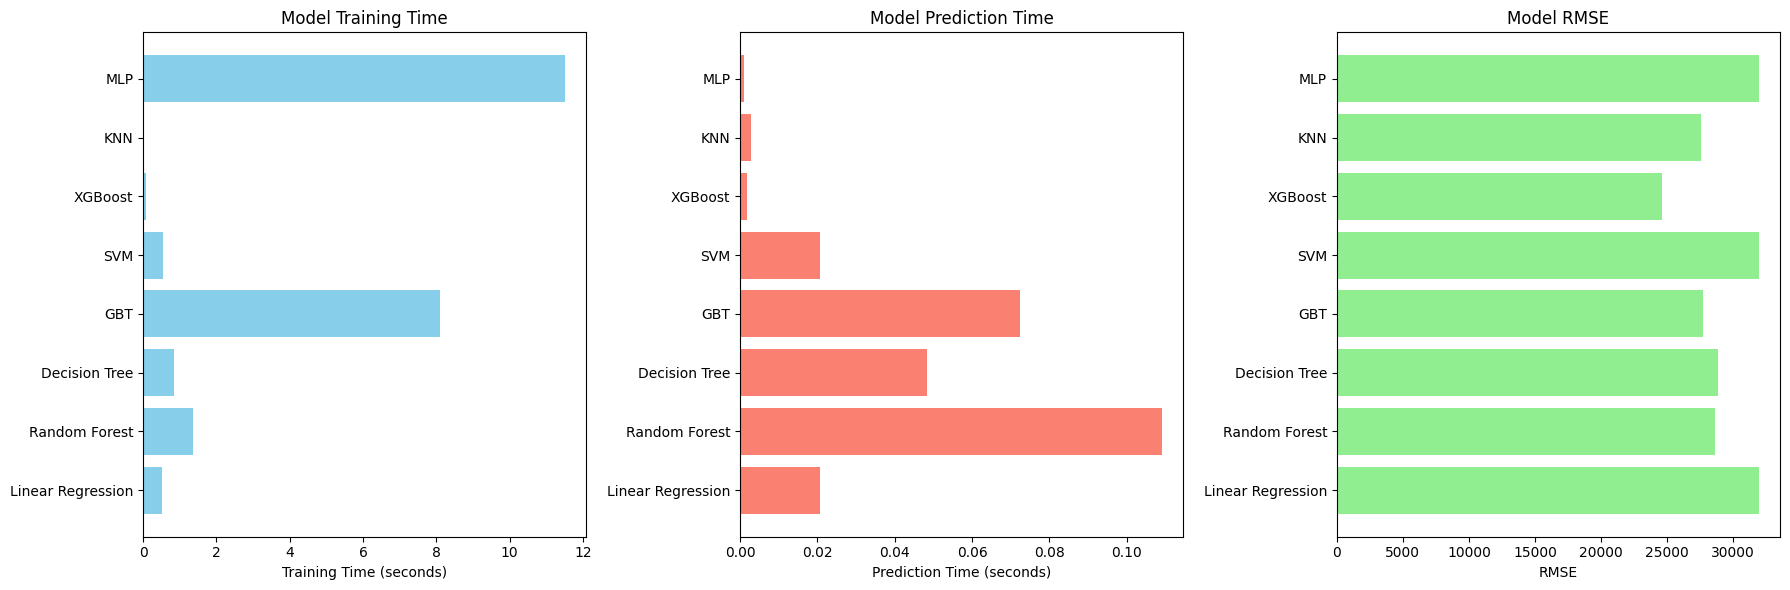

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the results list to a pandas DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plotting the metrics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Training Time Plot
ax[0].barh(results_df['Model'], results_df['Training Time (s)'], color='skyblue')
ax[0].set_xlabel('Training Time (seconds)')
ax[0].set_title('Model Training Time')

# Prediction Time Plot
ax[1].barh(results_df['Model'], results_df['Prediction Time (s)'], color='salmon')
ax[1].set_xlabel('Prediction Time (seconds)')
ax[1].set_title('Model Prediction Time')

# RMSE Plot
ax[2].barh(results_df['Model'], results_df['RMSE'], color='lightgreen')
ax[2].set_xlabel('RMSE')
ax[2].set_title('Model RMSE')

plt.tight_layout()
plt.show()


In [60]:
def predict_salary(job_title: str, search_city: str):
    # Step A: Create a new DataFrame for the user input
    user_df = spark.createDataFrame([(job_title, search_city)], ["title", "search_city"])

    # Step B: Apply StringIndexers for title and search_city
    title_indexer = StringIndexer(inputCol="title", outputCol="title_index_new").fit(df)
    user_df = title_indexer.transform(user_df)

    city_indexer = StringIndexer(inputCol="search_city", outputCol="search_city_index_new").fit(df)
    user_df = city_indexer.transform(user_df)

    # Step C: Assemble features using the new index columns
    assembler = VectorAssembler(inputCols=["title_index_new", "search_city_index_new"], outputCol="features")
    user_df = assembler.transform(user_df)

    # Step D: Scale features using the scaler model
    user_df = scaler_model.transform(user_df)

    # Step E: Convert scaled features to numpy for XGBoost
    user_features = np.array(user_df.select("scaled_features").collect()[0][0])
    dinput = xgb.DMatrix(np.array([user_features]))

    # Step F: Get prediction using XGBoost model
    predicted_salary = model.predict(dinput)[0]

    return predicted_salary

# Example: Take input from user
job_input = input("Enter job title: ")
city_input = input("Enter location: ")

# Get prediction
predicted_salary = predict_salary(job_input, city_input)
print(f"Predicted Average Salary (XGBoost): ${predicted_salary:.2f}")

Enter job title: CTO
Enter location: Denver
Predicted Average Salary (XGBoost): $60163.19
